In [1]:
#
# notebook config and settings
#

# regex for query results
search_regex = ".*(Search.*)__(.*)__sz_(\d+)_of_(.+)__q_(\d+)__k_(\d+)__(.+)____([\d\.]+).csv"

# all the dataset sizes
dset_sizes = [ 1000000, 2000000, 5000000, 10000000 ]

# all the query set sizes
query_sizes = [ 1000 ]

# all the k neighbors
ks = [ 10, 20, 50, 100 ]

# index names
indexes = [ "gemini", "hnsw" ]

In [2]:
# python imports

from matplotlib import pyplot as plt
import glob
import os
import re
import pandas as pd

In [3]:
# Look for the query results files
# parse the details from the filename
# and load into a master frame

all_dfs = []

csvs = glob.glob( os.path.join("results", "*.csv" ) )

for csv in csvs:
    # match filename via regex
    matches = re.match( search_regex, csv ) 
    if matches:
        # extract elements of the query experiment from file name
        items = matches.groups()
        #print("items", items)
        op = items[0]
        machine = "?"
        if op.find("-")>0:
            machine = "-".join( op.split("-")[1:] )
        weaviate_class = items[1]
        dset_size = int(items[2])
        dset = items[3]
        tot_queries = int(items[4])
        k = int(items[5])
        idx = items[6]
        bitsize=-1
        cacheing=None
        if idx.startswith("gemini"): 
            cacheing=False
            parts = idx.split("_")
            idx = parts[0]
            bitsize = int( parts[-1] )
        elif idx.startswith("hnsw"):
            cacheing=True # because the older ones we used the default
            parts = idx.split("__")
            if len(parts)>1 and parts[1].startswith("allowcacheing"):
                cacheing = False if parts[1].split("_")[1]=="False" else True
                idx = parts[0]
                #print(cacheing)        
        ts = items[7]
        
        # load the csv
        df = pd.read_csv( csv )
        
        # inject exp attributes as column
        df['machine'] = machine
        df['dset_size'] = dset_size
        df['dset'] = dset
        df['k'] = k
        df['idx'] = idx
        df['bits'] = bitsize
        df['cacheing']=cacheing
        df['ts'] = ts
        all_dfs.append(df)
        continue
                 
master_df = pd.concat(all_dfs)   
#print(master_df.columns)
#print(master_df)

In [4]:
# Convert searchTime to milliseconds

master_df['searchtime_ms'] = \
    master_df.apply( lambda row: row['searchTime']/1000000.0, axis=1 )
#print(master_df['idx'].unique())

In [5]:
# Do some dataframe filtering...

# Let's not include my local laptop test runs
master_df = master_df[ ~(master_df["machine"]=="Georges-MacBook-Pro.local") ]
#print(master_df['idx'].unique())

In [6]:
# Get the mean/median of recall and searchtime for all experiment runs

#print( master_df[ master_df['k']==10 ]['idx'].unique())

# use mean for recall
recall_df = master_df[ master_df['k']==10 ].\
    groupby( [ "ts", "idx", "dset_size", "bits", "cacheing" ] )[['recall']].mean()
recall_df.reset_index(inplace=True) # flatten multilevel index you get from groupby.mean
#print(recall_df)

# use median for searchtime
searchtime_df = master_df[ master_df['k']==10 ].\
    groupby( [ "ts", "idx", "dset_size", "bits", "cacheing" ] )[['searchtime_ms']].median()
searchtime_df.reset_index(inplace=True) # flatten multilevel index you get from groupby.mean

# join on 'ts' column
recall_vs_searchtime = pd.merge( recall_df, searchtime_df[['ts','searchtime_ms']], on='ts')
print(recall_vs_searchtime[['idx','dset_size','bits','cacheing','recall','searchtime_ms']])

       idx  dset_size  bits  cacheing  recall  searchtime_ms
0   gemini      10000    64     False  0.9988       8.415759
1   gemini      10000    64     False  0.9988       8.051132
2   gemini    1000000    64     False  0.9405       8.245971
3   gemini    1000000    64     False  0.9405       8.280355
4     hnsw   10000000    -1      True  0.9729       4.770952
5     hnsw   10000000    -1      True  0.9729       2.783028
6     hnsw   10000000    -1      True  0.9729       3.925200
7     hnsw    5000000    -1      True  0.9762       6.791923
8     hnsw    5000000    -1      True  0.9762       1.743693
9     hnsw    5000000    -1      True  0.9762       1.734729
10    hnsw    5000000    -1      True  0.9762       2.065146
11    hnsw    2000000    -1      True  0.9833       2.731966
12    hnsw    2000000    -1      True  0.9833       1.281086
13    hnsw    2000000    -1      True  0.9833       1.526998
14    hnsw    1000000    -1      True  0.9875       2.692244
15    hnsw    1000000   

[False  True]


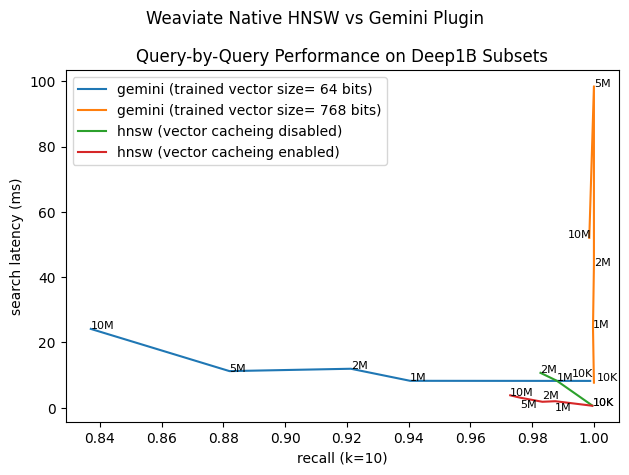

In [29]:
# Let's plot recall vs searchtime 
# showing dataset size trend for 
# each (index_type,bitsize) combo for gemini
# and just one line for hnsw.

# Get all plot points
all_points = [ (row["recall"], row["searchtime_ms"]) \
        for idx, row in recall_vs_searchtime[['recall','searchtime_ms']].iterrows() ]

# 
# Get plot lines for dataset size trends 
#

# groupby the experimental conditions
grps = recall_vs_searchtime.groupby(['idx','dset_size','bits','cacheing'])
recall_vs_searchTime_mean = grps.mean(numeric_only=True)  # choosing mean here because we dealt per query outliers earlier
recall_vs_searchTime_mean.reset_index(inplace=True)

# get the unique experiment parameters
idxs = recall_vs_searchTime_mean['idx'].unique()
bitses = recall_vs_searchTime_mean['bits'].unique()
cacheings = recall_vs_searchTime_mean['cacheing'].unique()
print(cacheings)
szs = recall_vs_searchTime_mean['dset_size'].unique()

# loop through all parameter combinations to get a dset_size line
for idx in idxs: # iterate unique indexes
    for bits in bitses: # iterate all different bit sizes (hnsw=-1)
        for cacheing in cacheings: # iterate all different cache settings [gemini=False]
        
            # get the plot points for dset_size trend
            line_df = recall_vs_searchTime_mean[ \
                (recall_vs_searchTime_mean["idx"]==idx) & \
                (recall_vs_searchTime_mean["bits"]==bits) & \
                (recall_vs_searchTime_mean["cacheing"]==cacheing) ]
            if line_df.shape[0]==0: continue # don't plot if there are no experiments yet
                     
            # sort by dset_size to plot that trend as a line
            line_df = line_df.sort_values(by=['dset_size'])
                              
            # extract just the points of the line
            line_pts = [ (row['recall'], row['searchtime_ms'], \
                          row['dset_size'] ) for idx, row in line_df.iterrows() ]
            xs = [ pt[0] for pt in line_pts ]
            ys = [ pt[1] for pt in line_pts ]
            
            # need dset_size for line annotations
            dset_size = [ pt[2] for pt in line_pts ]

            # labels depend on the index, bitsize, and/or cacheing
            if idx=="gemini":
                label = "%s (trained vector size= %d bits)" % (idx, bits)
            elif idx=="hnsw":
                label = "%s (vector cacheing %s)" % (idx, "enabled" if cacheing else "disabled")
            else:
                label = "%s" % idx

            # plot the line and annotation
            plt.plot( xs, ys, label=label )
            for pt in line_pts:
                dset_size = pt[2]
                if dset_size==10000: dset = '10K'
                elif dset_size==1000000: dset = '1M'
                elif dset_size==2000000: dset = '2M'
                elif dset_size==5000000: dset = '5M'
                elif dset_size==10000000: dset = '10M'
                
                # custom data to nudge annotation text
                off = (0,0)
                if idx=="hnsw" and cacheing==True:
                    if dset=="1M":
                        off = (0.0, -3)
                    if dset=="2M":
                        off = (0.0, 1)
                    elif dset=="5M":
                        off = (0.0, -3)
                elif idx=="gemini" and bits==768:
                    if dset=="10K":
                        off = (-0.007,2)
                    elif dset=="10M":
                        off = (-0.007,0)
                elif idx=="gemini" and bits==64:
                    if dset=="10K":
                        off = (0.002,0)
                plt.annotate( dset, (pt[0], pt[1]), fontsize=8, \
                             xytext=(pt[0] + off[0], pt[1] + off[1]) )
                

plt.legend(loc=0)
plt.xlabel("recall (k=10)")
plt.ylabel("search latency (ms)")
plt.suptitle("Weaviate Native HNSW vs Gemini Plugin")
plt.title("Query-by-Query Performance on Deep1B Subsets" )
plt.tight_layout()
plt.savefig("results/plot.png",bbox_inches='tight')